In [268]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style="darkgrid")

from sklearn.feature_selection import chi2, f_classif
from sklearn.decomposition import PCA

In [250]:
date_fmt = lambda x: pd.datetime.strptime(x.split()[0], '%Y-%m-%d')

users = pd.read_csv('takehome_users.csv', encoding='latin1', parse_dates=['creation_time'], date_parser=date_fmt)
users['last_session_creation_time'] = pd.to_datetime(pd.to_datetime(users['last_session_creation_time'], 
                                                                    unit='s').dt.strftime('%Y-%m-%d'))

user_en = pd.read_csv('takehome_user_engagement.csv', encoding='latin1', parse_dates=['time_stamp'], date_parser=date_fmt)

In [251]:
#check null values and types
user_en.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null datetime64[ns]
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.8 MB


In [252]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null datetime64[ns]
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null datetime64[ns]
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: datetime64[ns](2), float64(1), int64(4), object(3)
memory usage: 937.6+ KB


### Adopted user

In [253]:
# find adopted users
seven_day_login = user_en.set_index('time_stamp').groupby('user_id').resample('7D').sum()
adopted_users = seven_day_login[seven_day_login['visited'] >= 3].index.get_level_values(0).unique().values

In [254]:
# created bool column to identify adopted users
users['adopted'] = (users['object_id'].isin(adopted_users)).astype(int)

### Feature Engineering

In [260]:
# add 2 features - days since joining, last login 
users.last_session_creation_time.fillna(users.creation_time, inplace=True)
users['joined_days'] = (users.creation_time - users.creation_time.min()).dt.days
users['last_login'] = (users.last_session_creation_time.max() - users.last_session_creation_time).dt.days

In [192]:
# add 2 features - invited by a user Y/N, invited someone Y/N
users['invited_by_user'] = (~users.invited_by_user_id.isna()).astype(int)
users['invited_user'] = (users.object_id.isin(users.invited_by_user_id.unique())).astype(int)

In [193]:
# drop unecessary columns
users = users.drop(columns=['name', 'email', 'object_id', 'creation_time', 'last_session_creation_time', 
                            'invited_by_user_id'])

### Data Visualisations

In [120]:
def plot_pct(x, hue, df, ax):
    y = 'pct'
    pct = df.groupby(x)[hue].value_counts(normalize=True).rename(y).reset_index()
    return sns.barplot(x=x, y=y, hue=hue, data=pct, ax=ax)

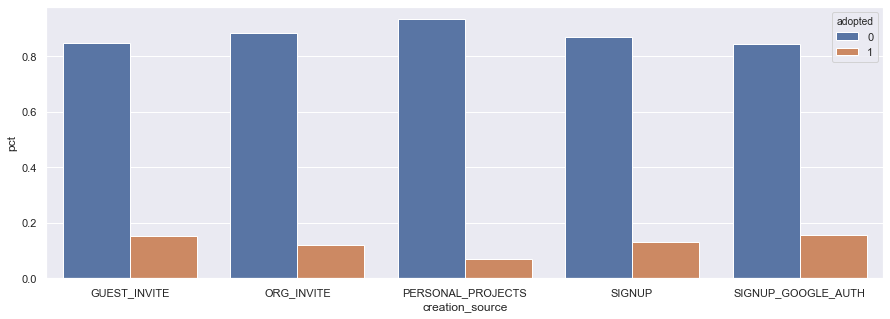

In [121]:
# plot user type by creation source
fig, ax = plt.subplots(figsize=(15, 5))
plot_pct('creation_source', 'adopted', users, ax)
plt.show()

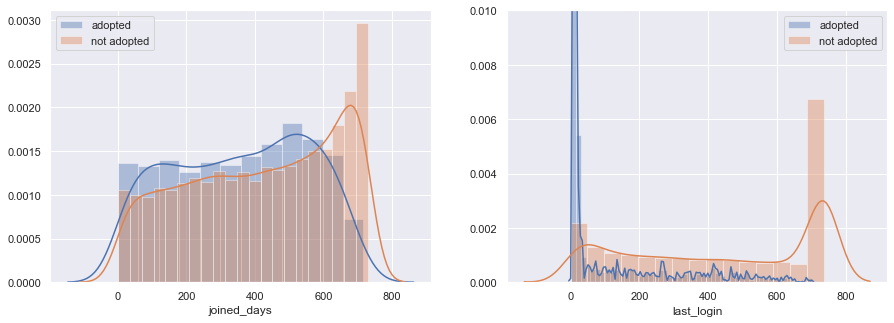

In [13]:
# plot user type by days since join and last login
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
sns.distplot(users[users['adopted'] == 1].joined_days, ax=ax1, label='adopted')
sns.distplot(users[users['adopted'] == 0].joined_days, ax=ax1, label='not adopted')
ax1.legend()

sns.distplot(users[users['adopted'] == 1].fillna(users.last_login.max()).last_login, ax=ax2, label='adopted')
sns.distplot(users[users['adopted'] == 0].fillna(users.last_login.max()).last_login, ax=ax2, label='not adopted')
ax2.legend()
plt.ylim([0, 0.01])
plt.show()

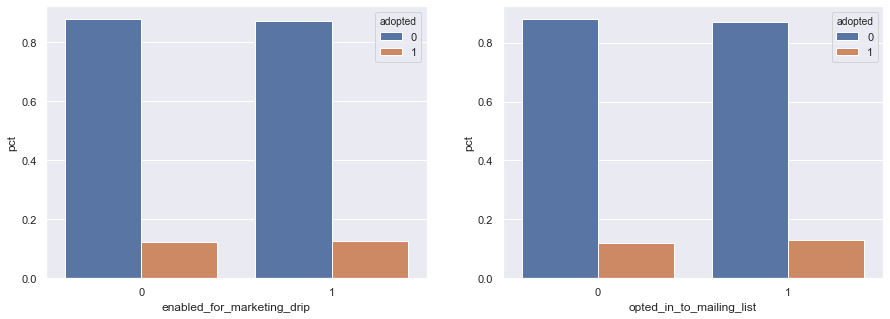

In [124]:
x_1, x_2, hue = 'enabled_for_marketing_drip', 'opted_in_to_mailing_list', 'adopted'

f, ax = plt.subplots(1, 2, figsize=(15, 5))
plot_pct(x_1, hue, users, ax[0])
plot_pct(x_2, hue, users, ax[1])
plt.show()

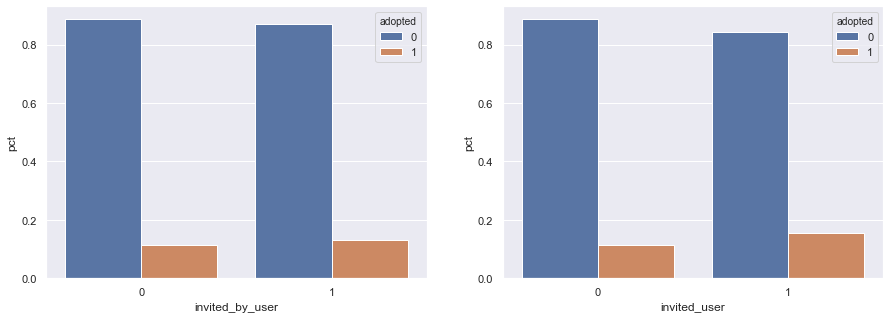

In [123]:
x_1, x_2, hue = 'invited_by_user', 'invited_user', 'adopted'

f, ax = plt.subplots(1, 2, figsize=(15, 5))
plot_pct(x_1, hue, users, ax[0])
plot_pct(x_2, hue, users, ax[1])
plt.show()

### Feature Selection 

In [234]:
X = pd.get_dummies(users.drop(columns='adopted'))
y = users['adopted']

In [276]:
num_features = ['joined_days', 'last_login']
label_features = X.columns[~X.columns.isin(num_features)]

In [236]:
print('Category features:')
print(label_features)
print('Numerical features:')
print(num_features)

Category features:
Index(['opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'org_id',
       'invited_by_user', 'invited_user', 'creation_source_GUEST_INVITE',
       'creation_source_ORG_INVITE', 'creation_source_PERSONAL_PROJECTS',
       'creation_source_SIGNUP', 'creation_source_SIGNUP_GOOGLE_AUTH'],
      dtype='object')
Numerical features:
['joined_days', 'last_login']


In [237]:
# chi-2 test for categorical features - use confidence interval of 95%
rejected = []
for label in zip(label_features, chi2(X[label_features], y)[1]):
    print(label, 'rejected' if label[1] >.05 else 'accepted')
    if label[1] > 0.05:
        rejected.append(label[0])

('opted_in_to_mailing_list', 0.3231222981092613) rejected
('enabled_for_marketing_drip', 0.6050730985193848) rejected
('org_id', 0.0) accepted
('invited_by_user', 0.06305397135316419) rejected
('invited_user', 1.9270189083332467e-07) accepted
('creation_source_GUEST_INVITE', 1.2431417274689943e-05) accepted
('creation_source_ORG_INVITE', 0.4048276027729488) rejected
('creation_source_PERSONAL_PROJECTS', 2.4149328147347095e-14) accepted
('creation_source_SIGNUP', 0.2050006686577206) rejected
('creation_source_SIGNUP_GOOGLE_AUTH', 0.00011411249701106666) accepted


In [238]:
# anova test for non-categorical columns
for label in zip(num_features, f_classif(X[num_features], y)[1]):
    print(label, 'rejected' if label[1] >.05 else 'accepted')

('joined_days', 8.316576518094806e-25) accepted
('last_login', 0.0) accepted


In [239]:
#handling org_ids which are technically cateogrical variables
org_id_labels = pd.get_dummies(X.org_id.astype('category'))
p_values = chi2(org_id_labels, y)[1]

rejected_orgid = []
for id in np.argwhere(p_values > 0.05):
    rejected_orgid.append('org_id_'+str(id[0]))

In [244]:
X = X.drop(columns=rejected)
X['org_id'] = X['org_id'].astype('category')
X = pd.get_dummies(X)
X = X.drop(columns=rejected_orgid)

In [247]:
print(X.columns)

Index(['joined_days', 'last_login', 'invited_user',
       'creation_source_GUEST_INVITE', 'creation_source_PERSONAL_PROJECTS',
       'creation_source_SIGNUP_GOOGLE_AUTH', 'org_id_0', 'org_id_1',
       'org_id_2', 'org_id_6', 'org_id_36', 'org_id_44', 'org_id_62',
       'org_id_82', 'org_id_116', 'org_id_117', 'org_id_152', 'org_id_156',
       'org_id_161', 'org_id_181', 'org_id_218', 'org_id_225', 'org_id_235',
       'org_id_238', 'org_id_270', 'org_id_273', 'org_id_280', 'org_id_281',
       'org_id_282', 'org_id_289', 'org_id_291', 'org_id_305', 'org_id_306',
       'org_id_318', 'org_id_343', 'org_id_345', 'org_id_366', 'org_id_387',
       'org_id_392', 'org_id_399', 'org_id_400', 'org_id_415'],
      dtype='object')


<b>Statistical analysis has shown that the columns above are the best predictors of adopted users. We can further fine tune this by implementing our predictive model and looking at feature importance values where features with very low importances can be removed iteratively from our dataset. Currently, we are only looking at each feature's independent impact on the target. We have yet to look at possible correlations between the features that can also affect our model. Here, we will only look at the relationships between the numerical features as doing the same for categorical features is not as straightforward. 

In [267]:
print('The correlation between the numerical features is {:.2f}'.format(np.corrcoef(X.last_login, X.joined_days)[0][1]))

The correlation between the numerical features is -0.84


<b>Given the high correlation, we could either choose one of the features or perform dimensionality reduction. 